## **4. Keywords Clustering** 
We will compare different models implemeting each of these parameters:
- K-Means vs Expectation maximization VS Agglomerative algorithm
- Cosine vs euclidean distance 
- One-hot vs Sentence transformers embedding
- 50, 100, 150, 200 extracted features

*En grande partie basé sur le tutoriel suivant* :   
https://colab.research.google.com/drive/1HHNFjKlip1AaFIuvvn0AicWyv6egLOZw?usp=sharing#scrollTo=zhP1daroRzRV    
(Une approche à base de Word embedding - on pourrait utiliser les scores TF-IDF ou OKapi pour les traits discriminants plutôt que la fréquence (voir plus bas))

In [107]:
from pandas import *
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
import matplotlib.pyplot as plt

In [108]:
algorithmes = ['K-means', 'GAAC', 'AgglomerativeClustering', 'Expectation-Maximization']
embeddings = ['One-Hot', 'Sentence transformers']
distances = [None]
features = [50, 100, 150, 200]

results = []
for algorithme in algorithmes:
    for embedding in embeddings:
        for distance in distances:
            for feature in features:
                results.append(\
                    {'algorithme' : algorithme,\
                     'embedding': embedding, \
                     'distance': distance, \
                     'N features': feature, \
                     'K (nb clusters)' : None,\
                     'Score Silhouette': None})

# On va remplir ce dictionnaire avec les bons scores au fur et à mesure qu'on expérimente
results = DataFrame(results)
results

,algorithme,embedding,distance,N features,K (nb clusters),Score Silhouette
0,K-means,One-Hot,None,50,None,None
1,K-means,One-Hot,None,100,None,None
2,K-means,One-Hot,None,150,None,None
3,K-means,One-Hot,None,200,None,None
4,K-means,Sentence transformers,None,50,None,None
5,K-means,Sentence transformers,None,100,None,None
6,K-means,Sentence transformers,None,150,None,None
7,K-means,Sentence transformers,None,200,None,None
8,GAAC,One-Hot,None,50,None,None
9,GAAC,One-Hot,None,100,None,None


**Importer la liste de termes candidats avec leur fréquence**

In [109]:
# path = '../05-transformation/'
# acteur = 'pinel'

# csv_file = acteur + '_weighting_OKapiBM25.csv'

In [110]:
import glob
import pandas as pd

# get data file names
path ='../05-transformation'
filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True).drop(columns=["Unnamed: 0"])

In [111]:
big_frame

big_frame['TF + DF']= big_frame['Fréquence (TF)'] + big_frame['Fréquence documentaire (DF)']
# Test

In [112]:
csv = big_frame[big_frame['isMeSHTerm'] == True].drop(columns = ['Terme formatté', 'TF (sklearn)', 'DF (sklearn)'])

In [113]:
from pandas import *

# with open(path+csv_file, encoding='utf-8') as f:
#     csv = read_csv(f).drop(columns = ['Unnamed: 0', 'Terme formatté', 'TF (sklearn)', 'DF (sklearn)']) #[['Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)']]
#     csv['TF + DF']= csv['Fréquence (TF)'] + csv['Fréquence documentaire (DF)']
#     # Test
#     csv = csv[csv['isMeSHTerm'] == True]
# csv

*Embedding : One-hot encoding*  
> One Hot encoding is a representation of categorical variables as binary vectors. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

In [114]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("(\w+\'|\w+-\w+|\(|\)|\w+)")

file_path = "../04-filtrage/stopwords.txt"
with open(file_path, 'r', encoding="utf-8") as f:
    stopwords = [t.lower().strip('\n') for t in f.readlines()]

def to_tokens(kw, min_chars=2):
    """
    Transforms sentence to list of tokens.  

    Basic: transform special characters to ascii + lowercase.  
    Options:  
    - remove stopwords (provide list of stopwords)  
    - set minimum length for tokens: will remove any shorter token. 
    
    Returns sorted tokens
    """
    tokens = tokenizer.tokenize(kw) # split the string into a list of words
    tokens = [word for word in tokens if len(word) > min_chars] 
    tokens = [word for word in tokens if word not in stopwords] 
    
    tokens = set(tokens) # to remove duplicates
    tokens = sorted(tokens) # converts our set back to a list and sorts words in alphabetical order
    return tokens

In [115]:
keywords_oh = csv.drop(columns=['Structure syntaxique', "LLR", "TF-IDF",	"OkapiBM25"])[["Corpus",	"Terme", "Fréquence (TF)",	"Fréquence documentaire (DF)", "TF + DF", "isMeSHTerm",	"isTaxoTerm"]]

In [116]:
keywords_oh

,Corpus,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,isMeSHTerm,isTaxoTerm
44,ciusss_centresud,orthèses plantaires,28,10,38,True,False
102,ciusss_centresud,sécurité du travail,18,18,36,True,False
118,ciusss_centresud,médecine familiale,22,12,34,True,True
156,ciusss_centresud,moteur de recherche,30,30,60,True,False
261,ciusss_centresud,qualité de vie,22,14,36,True,False
...,...,...,...,...,...,...,...
12758,pinel,congé de maladie,66,118,184,True,False
12825,pinel,gestion du risque,18,12,30,True,False
12827,pinel,troubles mentaux,24,18,42,True,False
12844,pinel,santé publique,26,12,38,True,True


In [117]:
keywords_oh["tokens"] = keywords_oh["Terme"].apply(lambda x: to_tokens(
    x,
    min_chars=2,
))

## Test - ça fait pas beaucoup de sens de cluster des unigrammes, on va donc seulement retenir des n-grammes où n est au-dessus de 2
# keywords_oh["len"] = keywords_oh["tokens"].apply(lambda x : len(x))
# keywords_oh = keywords_oh[keywords_oh['len'] > 1].drop(columns=["len"])

In [170]:
from collections import Counter

vocab = sorted(set(keywords_oh["tokens"].explode()))
len(vocab)

counter = Counter(keywords_oh["tokens"].explode().to_list())
vocab = []

# Ici, ça pourrait être intéressant de retenir sur la base du score TF-IDF ou OKapi
for key,value in counter.most_common(100):
    vocab.append(key)
len(vocab)

KeyError: 'tokens'

In [171]:
def to_vector(keyword,vocab):
    """
    Calculates vector of keyword on given vocabulary.

    Returns vector as a list of values.  
    """
    vector = []
    for word in vocab:
        if word in keyword:
            vector.append(1)
        else:
            vector.append(0)
    return vector

# Remarque : le type d'embedding qui est fait ici est du style 'One-hot encoding (binaire - si le terme est présent = 1, sinon 0) ; mais il existe d'autres manière de 
# représenter la matrice de cooccurrences qu'avec des scores binaires
keywords_oh["vector"] = keywords_oh["tokens"].apply(lambda x: to_vector(x,vocab))
keywords_oh

KeyError: 'tokens'

*Embedding : Sentence transformers*  

> "A **transformer** is a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part  of the input data.
Transformers are increasingly the model of choice for NLP problems, replacing RNN models such as long short-term memory (LSTM). The additional  training parallelization allows training on larger datasets. This led to the development of pretrained systems such as BERT (Bidirectional Encoder Representations from Transformers) and GPT (Generative Pre-trained Transformer), which were trained with large language datasets, such as the Wikipedia Corpus and Common Crawl, and can be fine-tuned for specific tasks."   
  
(https://en.wikipedia.org/wiki/Transformer_(machine_learning_model))


In [172]:
# On va utiliser un modèle BERT/sentence transformers (fr) pour extraire nos embeddings plutôt que des simples one-hot encoding
from sentence_transformers import SentenceTransformer
model =  SentenceTransformer("dangvantuan/sentence-camembert-large")

keywords_st = csv

## Test - ça fait pas beaucoup de sens de cluster des unigrammes, on va donc seulement retenir des n-grammes où n est au-dessus de 2
keywords_st["tokens"] = csv["Terme"].apply(lambda x: to_tokens(
    x,
    min_chars=2,
))

# keywords_st["len"] = keywords_st["tokens"].apply(lambda x : len(x))
# keywords_st = keywords_st[keywords_st['len'] > 1].drop(columns=["len"])

sentences = keywords_st['Terme'].tolist()

c:\Users\p1115145\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:560: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


In [173]:
embeddings = model.encode(sentences)

#### **K-means clustering** (*sklearn*)


*Un premier essai sur nos one-hot embeddings*

In [174]:
K = range(20, len(vocab))
silhouette_scores = []

for k in K:
    X = keywords_oh["vector"].to_list()
    km = KMeans(n_clusters=k, init='k-means++', algorithm='elkan', max_iter=200, n_init=1).fit(X)

    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the k-means result.
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)
    km.fit(X)

    labels = km.labels_
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])


print("Score Silhouette")
print("On va regrouper nos termes en " + str(true_k) + " clusters.")
df

Score Silhouette
On va regrouper nos termes en 46 clusters.


,Nombre de clusters (k),Score Silhouette
0,20,0.731427
1,21,0.755685
2,22,0.735461
3,23,0.771881
4,24,0.765934
5,25,0.776417
6,26,0.753842
7,27,0.766955
8,28,0.781215
9,29,0.786618


In [175]:
algorithme = 'K-means'
embedding = 'One-Hot'
distance = 'Euclidean'
features = len(vocab)

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'K (nb clusters)'] = true_k

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'Score Silhouette'] = df['Score Silhouette'].max()

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'distance'] = distance

results[(results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['distance'] == distance) & \
    (results['N features'] == features)]

,algorithme,embedding,distance,N features,K (nb clusters),Score Silhouette
0,K-means,One-Hot,Euclidean,50,46,0.866062


In [176]:
X = keywords_oh["vector"].to_list()
km = KMeans(n_clusters=true_k, init='k-means++', algorithm='elkan', max_iter=200, n_init=1).fit(X)

# Run LSA
# Since LSA/SVD results are not normalized,
# we redo the normalization to improve the k-means result.
svd = TruncatedSVD(n_components=true_k)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)
km.fit(X)

labels = km.labels_
keywords_oh["kmeans"] = list(km.labels_)

keywords_oh

C:\Users\p1115145\AppData\Local\Temp\ipykernel_10864\1727009219.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_oh["kmeans"] = list(km.labels_)


,Corpus,Cluster_kmeans_euclidean,Cluster_GMM,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,isMeSHTerm,isTaxoTerm,vector,kmeans
1659,inesss,accès douloureux,accès douloureux,accès douloureux,48,4,52,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37
6592,inesss,accès douloureux,accès douloureux,accès aux soins,18,8,26,True,False,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37
12371,pinel,accès douloureux,accès douloureux,accès aux installations,16,16,32,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37
11876,inesss,aide médicale,aide médicale,aide médicale,216,200,416,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",23
1610,ciusss_centresud,aide médicale,aide médicale,aide financière,32,22,54,True,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",23
...,...,...,...,...,...,...,...,...,...,...,...
11866,inesss,voies biliaires,cancer des voies biliaires,voies respiratoires,26,26,52,True,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44
8825,inesss,étude clinique,étude clinique,étude clinique,30,26,56,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13
6406,inesss,étude clinique,étude clinique,étude rétrospective,22,22,44,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13
7223,inesss,étude clinique,étude clinique,étude multicentrique,16,16,32,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13


In [177]:
current_labels = set(km.labels_.tolist())

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords_oh[keywords_oh["kmeans"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords_oh['Cluster_kmeans_euclidean'] = keywords_oh['kmeans'].map(desired_labels)

C:\Users\p1115145\AppData\Local\Temp\ipykernel_10864\853337490.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_oh['Cluster_kmeans_euclidean'] = keywords_oh['kmeans'].map(desired_labels)


In [178]:
#keywords = keywords[['Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'Cluster']]
keywords_oh.sort_values(["Cluster_kmeans_euclidean"], 
        axis=0,
        ascending=[False], 
        inplace=True)

C:\Users\p1115145\AppData\Local\Temp\ipykernel_10864\2174501243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_oh.sort_values(["Cluster_kmeans_euclidean"],


In [179]:
#keywords = keywords.drop(columns=['TF + DF', 'tokens', 'vector', 'kmeans'])

keywords_oh = keywords_oh[['Corpus', 'Cluster_kmeans_euclidean', 'Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'TF + DF', 'isMeSHTerm', 'isTaxoTerm', 'vector', 'kmeans']]
keywords_oh = keywords_oh.sort_values(['Cluster_kmeans_euclidean', 'Fréquence (TF)', 'Fréquence documentaire (DF)'],
              ascending = [True, False, False])

keywords_oh

,Corpus,Cluster_kmeans_euclidean,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,isMeSHTerm,isTaxoTerm,vector,kmeans
1659,inesss,accès douloureux,accès douloureux,48,4,52,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37
6592,inesss,accès douloureux,accès aux soins,18,8,26,True,False,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37
12371,pinel,accès douloureux,accès aux installations,16,16,32,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37
11876,inesss,aide médicale,aide médicale,216,200,416,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",23
1610,ciusss_centresud,aide médicale,aide financière,32,22,54,True,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",23
...,...,...,...,...,...,...,...,...,...,...
1499,ciusss_centresud,utilisation des services,services alimentaires,16,6,22,True,False,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",43
8825,inesss,étude clinique,étude clinique,30,26,56,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13
6406,inesss,étude clinique,étude rétrospective,22,22,44,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13
7223,inesss,étude clinique,étude multicentrique,16,16,32,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13


In [180]:
base_path = '../06-clustering/'
file_path = base_path + 'KMeans_onehot_euclidiean_' + str(len(vocab)) + '.csv'
keywords_oh.drop(columns=['vector', 'kmeans']).to_csv(file_path)

In [181]:
#keywords_oh.groupby("Cluster_kmeans_euclidean")["Terme"].count()

#### *Visualisation*

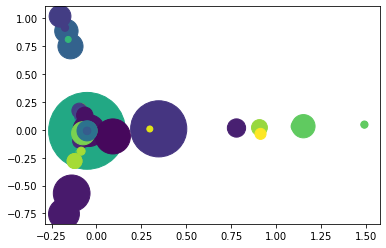

In [182]:
from sklearn.decomposition import PCA

vectors = keywords_oh["vector"].to_list()

pca = PCA(n_components=2).fit(vectors)
pca_2d = pca.transform(vectors)

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(pca_2d[:,0], pca_2d[:,1], c=keywords_oh["kmeans"], s=keywords_oh["TF + DF"])

#### **K-means clustering** (*sklearn*)


*Un deuxième essai, cette fois sur sur nos transformers embeddings*

In [183]:
K = range(20,len(vocab))
#Sum_of_squared_distances = []
silhouette_scores = []

for k in K:
    #true_k = int(input())
    X = embeddings
    kmeans = KMeans(n_clusters=k, init='k-means++', algorithm='elkan', max_iter=200, n_init=1).fit(X)
    #Sum_of_squared_distances.append(kmeans.inertia_)

    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the k-means result.
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)
    kmeans.fit(X)

    labels = kmeans.labels_
    #keywords["Cluster"] = list(kmeans.labels_)

    #original_space_centroids = svd.inverse_transform(X)
    #order_centroids = original_space_centroids.argsort()[:, ::-1]
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

# print("Méthode Elbow")
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

print("Score Silhouette")
print("On va regrouper nos termes en " + str(true_k) + " clusters.")
df

Score Silhouette
On va regrouper nos termes en 26 clusters.


,Nombre de clusters (k),Score Silhouette
0,20,0.161119
1,21,0.167591
2,22,0.165593
3,23,0.160887
4,24,0.163128
5,25,0.157903
6,26,0.170147
7,27,0.166841
8,28,0.151596
9,29,0.155900


In [184]:
algorithme = 'K-means'
embedding = 'Sentence transformers'
distance = 'Euclidean'
features = len(vocab)

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'K (nb clusters)'] = true_k

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'Score Silhouette'] = df['Score Silhouette'].max()

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'distance'] = distance


results[(results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['distance'] == distance) & \
    (results['N features'] == features)]

,algorithme,embedding,distance,N features,K (nb clusters),Score Silhouette
4,K-means,Sentence transformers,Euclidean,50,26,0.170147


In [185]:
X = embeddings
kmeans = KMeans(n_clusters=true_k, init='k-means++', algorithm='elkan', max_iter=200, n_init=1).fit(X)

# Run LSA
# Since LSA/SVD results are not normalized,
# we redo the normalization to improve the k-means result.
svd = TruncatedSVD(n_components=true_k)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)
kmeans.fit(X)

labels = kmeans.labels_
keywords_st["kmeans"] = list(kmeans.labels_)

keywords_st


,Corpus,Terme,Structure syntaxique,Fréquence (TF),Fréquence documentaire (DF),LLR,isMeSHTerm,isTaxoTerm,TF-IDF,OkapiBM25,TF + DF,tokens,kmeans,Cluster_kmeans_euclidean
2256,inesss,traumatisme craniocérébral,NOM ADJ,138,62,-inf,True,False,0.166159,25.302704,200,"[craniocérébral, traumatisme]",7,troubles neurocognitifs
4602,inesss,accident vasculaire cérébral,NOM ADJ ADJ,26,26,596.5593171465017,True,True,0.004984,14.488125,52,"[accident, cérébral, vasculaire]",14,troubles neurocognitifs
6832,inesss,traumatisme crânien,NOM ADJ,72,16,1322.2008504010244,True,False,0.067413,10.314632,88,"[crânien, traumatisme]",7,troubles neurocognitifs
6952,inesss,moelle épinière,NOM ADJ,24,20,509.9662199866364,True,False,0.049373,10.171306,44,"[moelle, épinière]",7,troubles neurocognitifs
8892,inesss,système nerveux,NOM ADJ,28,28,385.3771693800818,True,True,0.077279,7.477284,56,"[nerveux, système]",7,troubles neurocognitifs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3663,inesss,acides gras,NOM ADJ,98,94,-inf,True,False,0.041946,17.248465,192,"[acides, gras]",15,acides gras
7369,inesss,estrogènes conjugués,NOM ADJ,92,16,-inf,True,False,0.192448,9.545024,108,"[conjugués, estrogènes]",25,acides gras
10827,inesss,contraceptifs oraux,NOM ADJ,20,8,397.71153736185977,True,False,0.199179,5.104560,28,"[contraceptifs, oraux]",25,acides gras
3358,inesss,warfarine sodique,NOM ADJ,16,4,224.38553399735977,True,False,0.525219,18.494172,20,"[sodique, warfarine]",25,acides gras


In [186]:
current_labels = set(kmeans.labels_.tolist())

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords_st[keywords_st["kmeans"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords_st['Cluster_kmeans_euclidean'] = keywords_st['kmeans'].map(desired_labels)

In [187]:
#keywords = keywords[['Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'Cluster']]
keywords_st.sort_values(["Cluster_kmeans_euclidean"], 
        axis=0,
        ascending=[False], 
        inplace=True)

In [188]:
#keywords = keywords.drop(columns=['TF + DF', 'tokens', 'vector', 'kmeans'])

keywords_st = keywords_st[['Corpus', 'Cluster_kmeans_euclidean', 'kmeans', 'Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'TF + DF']]
keywords_st = keywords_st.sort_values(['Cluster_kmeans_euclidean', 'Fréquence (TF)', 'Fréquence documentaire (DF)'],
              ascending = [True, False, False])

keywords_st

,Corpus,Cluster_kmeans_euclidean,kmeans,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF
7791,inesss,analyse des données,5,dépistage néonatal,174,54,228
10477,inesss,analyse des données,5,revue systématique,124,102,226
3666,inesss,analyse des données,5,analyse des données,118,118,236
10645,inesss,analyse des données,5,diagnostic moléculaire,80,42,122
11500,inesss,analyse des données,5,innovations technologiques,70,46,116
...,...,...,...,...,...,...,...
4772,inesss,ténofovir disoproxil,25,prophylaxie préexposition,28,12,40
6990,inesss,ténofovir disoproxil,25,ostéoporose postménopausique,24,8,32
5852,inesss,ténofovir disoproxil,25,clavulanate de potassium,20,12,32
10827,inesss,ténofovir disoproxil,25,contraceptifs oraux,20,8,28


In [189]:
base_path = '../06-clustering/'
file_path = base_path + 'KMeans_transformers_euclidean_' + str(len(vocab)) + '.csv'
keywords_st.to_csv(file_path)

In [190]:
keywords_st.groupby("Cluster_kmeans_euclidean")["Terme"].count()

keywords_st

,Corpus,Cluster_kmeans_euclidean,kmeans,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF
7791,inesss,analyse des données,5,dépistage néonatal,174,54,228
10477,inesss,analyse des données,5,revue systématique,124,102,226
3666,inesss,analyse des données,5,analyse des données,118,118,236
10645,inesss,analyse des données,5,diagnostic moléculaire,80,42,122
11500,inesss,analyse des données,5,innovations technologiques,70,46,116
...,...,...,...,...,...,...,...
4772,inesss,ténofovir disoproxil,25,prophylaxie préexposition,28,12,40
6990,inesss,ténofovir disoproxil,25,ostéoporose postménopausique,24,8,32
5852,inesss,ténofovir disoproxil,25,clavulanate de potassium,20,12,32
10827,inesss,ténofovir disoproxil,25,contraceptifs oraux,20,8,28


#### *Visualisation*

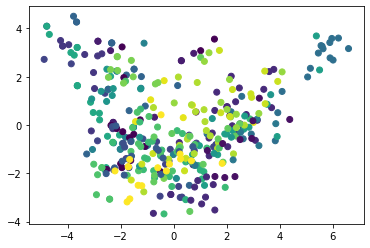

In [191]:
from sklearn.decomposition import PCA

vectors = embeddings

pca = PCA(n_components=2).fit(vectors)
pca_2d = pca.transform(vectors)

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(pca_2d[:,0], pca_2d[:,1], c=keywords_st['kmeans'])

### **K-means clustering** (*NLTK*)

Le but d'utiliser NLTK est de pouvoir prendre la distance cosinus entre les vecteurs plutôt que la distance Euclidienne, pour les embeddings basés sur le sentence transformer.

In [192]:
import nltk
import numpy as np
from numpy import array, ndarray
  
from sklearn import metrics

*(super long à rouler)*


In [193]:
from nltk import cluster
from nltk.cluster import KMeansClusterer
from nltk.cluster import cosine_distance
from nltk.cluster import euclidean_distance

K = range(20,len(vocab))
silhouette_scores = []
for k in K:
    X = embeddings
    clusterer = cluster.KMeansClusterer(true_k, distance=cosine_distance, avoid_empty_clusters=True, repeats=25)
    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the result.
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X = lsa.fit_transform(X)
    labels = clusterer.cluster(X, assign_clusters= True)
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

df[df['Nombre de clusters (k)'] == true_k]
df

,Nombre de clusters (k),Score Silhouette
0,20,0.182989
1,21,0.170350
2,22,0.156182
3,23,0.158911
4,24,0.161036
5,25,0.161313
6,26,0.152602
7,27,0.141115
8,28,0.146210
9,29,0.149439


In [194]:
algorithme = 'K-means'
embedding = 'Sentence transformers'
distance = 'Cosine'
features = len(vocab)

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'K (nb clusters)'] = true_k

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'Score Silhouette'] = df['Score Silhouette'].max()

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'distance'] = distance

results[(results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['distance'] == distance) & \
    (results['N features'] == features)]

,algorithme,embedding,distance,N features,K (nb clusters),Score Silhouette
4,K-means,Sentence transformers,Cosine,50,20,0.182989


In [195]:
keywords_st["kmeans_cosine"] = list(labels)

In [196]:
current_labels = set(labels)

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords_st[keywords_st["kmeans_cosine"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords_st['Cluster_kmeans_cosine'] = keywords_st['kmeans_cosine'].map(desired_labels)

keywords_st

,Corpus,Cluster_kmeans_euclidean,kmeans,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,kmeans_cosine,Cluster_kmeans_cosine
7791,inesss,analyse des données,5,dépistage néonatal,174,54,228,21,santé publique
10477,inesss,analyse des données,5,revue systématique,124,102,226,21,santé publique
3666,inesss,analyse des données,5,analyse des données,118,118,236,21,santé publique
10645,inesss,analyse des données,5,diagnostic moléculaire,80,42,122,21,santé publique
11500,inesss,analyse des données,5,innovations technologiques,70,46,116,21,santé publique
...,...,...,...,...,...,...,...,...,...
4772,inesss,ténofovir disoproxil,25,prophylaxie préexposition,28,12,40,13,temps de prothrombine
6990,inesss,ténofovir disoproxil,25,ostéoporose postménopausique,24,8,32,14,candidose buccale
5852,inesss,ténofovir disoproxil,25,clavulanate de potassium,20,12,32,1,services sociaux
10827,inesss,ténofovir disoproxil,25,contraceptifs oraux,20,8,28,14,candidose buccale


In [197]:
base_path = '../06-clustering/'
file_path = base_path + 'KMeans_transformers_cosine_' + str(len(vocab)) + '.csv'
keywords_oh.drop(columns=['vector', 'kmeans']).to_csv(file_path)

### **EM clustering** (*sklearn*)

> L'algorithme espérance-maximisation (en anglais expectation-maximization algorithm, souvent abrégé EM), est un algorithme itératif qui permet de trouver les paramètres du maximum de vraisemblance d'un modèle probabiliste lorsque ce dernier dépend de variables latentes non observables. 

(https://fr.wikipedia.org/wiki/Algorithme_esp%C3%A9rance-maximisation)

**sklearn.mixture GaussianMixture**  
https://www.analyticsvidhya.com/blog/2019/10/gaussian-mixture-models-clustering/  
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

*Encore une fois, on fait un premier essai sur nos one-hot embeddings*

In [198]:
from sklearn.mixture import GaussianMixture

K = range(20,len(vocab))
silhouette_scores = []
for k in K:
    X = keywords_oh["vector"].to_list()
    gmm = GaussianMixture(n_components=k, init_params='k-means++').fit(X)
    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the result.
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X = lsa.fit_transform(X)
    gmm.fit(X)
    labels = gmm.predict(X)
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

df[df['Nombre de clusters (k)'] == true_k]

,Nombre de clusters (k),Score Silhouette
26,46,0.864952


In [199]:
algorithme = 'Expectation-Maximization'
embedding = 'One-Hot'
features = len(vocab)

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'K (nb clusters)'] = true_k

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'Score Silhouette'] = df['Score Silhouette'].max()

results[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features)]

,algorithme,embedding,distance,N features,K (nb clusters),Score Silhouette
24,Expectation-Maximization,One-Hot,None,50,46,0.864952


In [200]:
results

,algorithme,embedding,distance,N features,K (nb clusters),Score Silhouette
0,K-means,One-Hot,Euclidean,50,46,0.866062
1,K-means,One-Hot,None,100,None,None
2,K-means,One-Hot,None,150,None,None
3,K-means,One-Hot,None,200,None,None
4,K-means,Sentence transformers,Cosine,50,20,0.182989
5,K-means,Sentence transformers,None,100,None,None
6,K-means,Sentence transformers,None,150,None,None
7,K-means,Sentence transformers,None,200,None,None
8,GAAC,One-Hot,None,50,None,None
9,GAAC,One-Hot,None,100,None,None


In [203]:
keywords_oh["GMM"] = list(labels)
current_labels = set(labels)

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords_oh[keywords_oh["GMM"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords_oh['Cluster_E-M'] = keywords_oh['GMM'].map(desired_labels)

keywords_oh

,Corpus,Cluster_kmeans_euclidean,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,isMeSHTerm,isTaxoTerm,vector,kmeans,GMM,Cluster_E-M
1659,inesss,accès douloureux,accès douloureux,48,4,52,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37,40,accès douloureux
6592,inesss,accès douloureux,accès aux soins,18,8,26,True,False,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37,39,accès aux soins
12371,pinel,accès douloureux,accès aux installations,16,16,32,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37,40,accès douloureux
11876,inesss,aide médicale,aide médicale,216,200,416,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",23,29,aide médicale
1610,ciusss_centresud,aide médicale,aide financière,32,22,54,True,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",23,29,aide médicale
...,...,...,...,...,...,...,...,...,...,...,...,...
1499,ciusss_centresud,utilisation des services,services alimentaires,16,6,22,True,False,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",43,12,services sociaux
8825,inesss,étude clinique,étude clinique,30,26,56,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,11,étude clinique
6406,inesss,étude clinique,étude rétrospective,22,22,44,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,11,étude clinique
7223,inesss,étude clinique,étude multicentrique,16,16,32,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,11,étude clinique


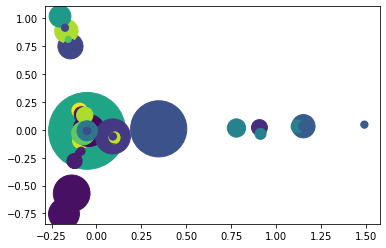

In [204]:
vectors = keywords_oh["vector"].tolist()

pca = PCA(n_components=2).fit(vectors)
pca_2d = pca.transform(vectors)

plt.scatter(pca_2d[:,0], pca_2d[:,1], c=keywords_oh["GMM"], s=keywords_oh["TF + DF"])

In [205]:
current_labels = set(labels)

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords_oh[keywords_oh["GMM"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords_oh['Cluster_GMM'] = keywords_oh['GMM'].map(desired_labels)

In [206]:
#keywords_oh = keywords_oh[['Cluster_kmeans_euclidean', 'Cluster_GMM', 'Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'TF + DF']]
keywords_oh = keywords_oh[['Corpus', 'Cluster_kmeans_euclidean', 'Cluster_GMM', 'Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'TF + DF', 'isMeSHTerm', 'isTaxoTerm', 'vector', 'kmeans']]
keywords_oh

,Corpus,Cluster_kmeans_euclidean,Cluster_GMM,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,isMeSHTerm,isTaxoTerm,vector,kmeans
1659,inesss,accès douloureux,accès douloureux,accès douloureux,48,4,52,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37
6592,inesss,accès douloureux,accès aux soins,accès aux soins,18,8,26,True,False,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37
12371,pinel,accès douloureux,accès douloureux,accès aux installations,16,16,32,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37
11876,inesss,aide médicale,aide médicale,aide médicale,216,200,416,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",23
1610,ciusss_centresud,aide médicale,aide médicale,aide financière,32,22,54,True,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",23
...,...,...,...,...,...,...,...,...,...,...,...
1499,ciusss_centresud,utilisation des services,services sociaux,services alimentaires,16,6,22,True,False,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",43
8825,inesss,étude clinique,étude clinique,étude clinique,30,26,56,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13
6406,inesss,étude clinique,étude clinique,étude rétrospective,22,22,44,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13
7223,inesss,étude clinique,étude clinique,étude multicentrique,16,16,32,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13


In [207]:
base_path = '../06-clustering/'
file_path = base_path + 'E-M_onehot_euclidean_' + str(len(vocab)) + '.csv'
keywords_oh.drop(columns=['vector', 'kmeans']).to_csv(file_path)

*Deuxième essai, cette fois sur les sentence embeddings / transformers*

In [208]:
K = range(20,len(vocab))
silhouette_scores = []
for k in K:
    X = embeddings
    gmm = GaussianMixture(n_components=k, init_params='k-means++').fit(X)
    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the result.
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X = lsa.fit_transform(X)
    gmm.fit(X)
    labels = gmm.predict(X)
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

df[df['Nombre de clusters (k)'] == true_k]

In [ ]:
algorithme = 'Expectation-Maximization'
embedding = 'Sentence transformers'
features = len(vocab)

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'K (nb clusters)'] = true_k

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'Score Silhouette'] = df['Score Silhouette'].max()

results[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features)]

,algorithme,embedding,distance,N features,K (nb clusters),Score Silhouette
28,Expectation-Maximization,Sentence transformers,None,50,48,0.14426


[...] to do : ajouter le EM clustering / sklearn avec le sentence embeddings

En fait je ne suis pas convaincue, parce que dans tous les cas ça ne donne jamais d'aussi bons résultats avec les sentence embeddings quant au scoresilhouette ; peut-être plus tard, mais peut-être pas une priorité.

### **EM clustering** (*NLTK*)

*Premier essai, sur les one-hot embeddings / bag-of-words*

Pas prioritaire non plus puisqu'on a déjà le EM Clustering fonctionnel avec celui de sk-learn

In [ ]:
# from nltk import cluster
# from nltk.cluster import KMeansClusterer, euclidean_distance

# #On initialise sur les kmeans
# vectors = [array(f) for f in keywords_oh['vector'].tolist()]

# clusterer = KMeansClusterer(true_k, euclidean_distance, initial_means=None, repeats=10)
# means = clusterer.cluster(vectors, True, trace=True)

# ##########
# clusterer = cluster.EMClusterer(means, bias=0.1)
# clusters = clusterer.cluster(vectors, True, trace=True)



*Deuxième essai, cette fois sur les sentence embeddings / transformers*  
(même chose)

In [ ]:
###########

### **Agglomerative clustering** (*NLTK / sklearn*)
> In data mining and statistics, hierarchical clustering (also called hierarchical cluster analysis or HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two types:  
> - Agglomerative: This is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
> - Divisive: This is a "top-down" approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.    
  
(https://en.wikipedia.org/wiki/Hierarchical_clustering)

**sklearn AgglomerativeClustering / one-hot embeddings**  
(le clusterer agglomératif de sklearn, qui permet d'utiliser la distance Euclidienne, mais pas celui d'NLTK)*

In [ ]:
from sklearn.cluster import AgglomerativeClustering

K = range(20,50)
Sum_of_squared_distances = []
silhouette_scores = []

for k in K:
    X = keywords_oh['vector'].tolist()
    clustering = AgglomerativeClustering().fit(X)

    #Sum_of_squared_distances.append(km.inertia_)

    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the k-means result.
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    clusters = clustering.labels_
    #keywords["Cluster"] = list(kmeans.labels_)

    #original_space_centroids = svd.inverse_transform(X)
    #order_centroids = original_space_centroids.argsort()[:, ::-1]
    silhouette_scores.append([k, metrics.silhouette_score(X, clusters)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

# print("Méthode Elbow")
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

print("Score Silhouette")
print("On va regrouper nos termes en " + str(true_k) + " clusters.")
df

Score Silhouette
On va regrouper nos termes en 20 clusters.


,Nombre de clusters (k),Score Silhouette
0,20,0.341044
1,21,0.340015
2,22,0.340604
3,23,0.339768
4,24,0.340060
5,25,0.339769
6,26,0.339335
7,27,0.339561
8,28,0.339335
9,29,0.339575


In [ ]:
algorithme = 'AgglomerativeClustering'
embedding = 'One-Hot'
distance = 'Euclidean'
features = len(vocab)

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'K (nb clusters)'] = true_k

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'Score Silhouette'] = df['Score Silhouette'].max()

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'distance'] = distance

results[(results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['distance'] == distance) & \
    (results['N features'] == features)]

,algorithme,embedding,distance,N features,K (nb clusters),Score Silhouette
16,AgglomerativeClustering,One-Hot,Euclidean,50,20,0.341044


**NLTK Group Average Agglomerative Clustering (GAAC) / Sentence transformers embeddings**

In [ ]:
from nltk.cluster import GAAClusterer

K = range(20,50)
Sum_of_squared_distances = []
silhouette_scores = []

for k in K:
    X = embeddings
    clusterer = GAAClusterer(k)

    #Sum_of_squared_distances.append(km.inertia_)

    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the k-means result.
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    clusters = clusterer.cluster(X, True)
    #keywords["Cluster"] = list(kmeans.labels_)

    #original_space_centroids = svd.inverse_transform(X)
    #order_centroids = original_space_centroids.argsort()[:, ::-1]
    silhouette_scores.append([k, metrics.silhouette_score(X, clusters)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

# print("Méthode Elbow")
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

print("Score Silhouette")
print("On va regrouper nos termes en " + str(true_k) + " clusters.")
df

Score Silhouette
On va regrouper nos termes en 20 clusters.


,Nombre de clusters (k),Score Silhouette
0,20,0.170385
1,21,0.163127
2,22,0.161378
3,23,0.170094
4,24,0.168870
5,25,0.159410
6,26,0.162526
7,27,0.144104
8,28,0.149465
9,29,0.147759


In [ ]:
algorithme = 'AgglomerativeClustering'
embedding = 'Sentence transformers'
distance = 'Cosine'
features = len(vocab)

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'K (nb clusters)'] = true_k

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'Score Silhouette'] = df['Score Silhouette'].max()

results.loc[ \
    (results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['N features'] == features), 'distance'] = distance

results[(results['algorithme'] == algorithme) & \
    (results['embedding'] == embedding) & \
    (results['distance'] == distance) & \
    (results['N features'] == features)]

,algorithme,embedding,distance,N features,K (nb clusters),Score Silhouette
20,AgglomerativeClustering,Sentence transformers,Cosine,50,20,0.170385


In [ ]:
from nltk.cluster import GAAClusterer

# use a set of tokens with 2D indices
vectors = embeddings

# test the GAAC clusterer with 4 clusters
clusterer = GAAClusterer(50)
clusters = clusterer.cluster(vectors, True)

keywords_st["GAAC"] = clusters

current_labels = set(clusters)

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords_oh[keywords_st["GAAC"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords_st['Cluster_GAAC'] = keywords_st['GAAC'].map(desired_labels)


C:\Users\p1115145\AppData\Local\Temp\ipykernel_10864\3085620768.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cluster = keywords_oh[keywords_st["GAAC"] == label]


*Il resterait à calculer les scores SSilhouettes pour différentes valeurs de K avec l'algorithme GAAC*

In [ ]:
keywords_st

,Corpus,Cluster_kmeans_euclidean,kmeans,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,kmeans_cosine,Cluster_kmeans_cosine,GAAC,Cluster_GAAC
3663,inesss,acides gras,14,acides gras,98,94,192,24,acides gras,46,bicarbonate de sodium
7369,inesss,acides gras,14,estrogènes conjugués,92,16,108,30,analyse des données,17,analyse des données
9818,inesss,acides gras,14,femmes enceintes,58,30,88,2,qualité de vie,46,bicarbonate de sodium
1375,ciusss_centresud,acides gras,14,conduite automobile,44,16,60,5,travailleur social,44,candidose buccale
11233,inesss,acides gras,14,contraceptif oral,36,12,48,14,colite ulcéreuse,42,colite ulcéreuse
...,...,...,...,...,...,...,...,...,...,...,...
2206,inesss,troubles neurocognitifs,19,démence frontotemporale,24,6,30,2,qualité de vie,46,bicarbonate de sodium
2932,inesss,troubles neurocognitifs,19,paralysie cérébrale,24,6,30,30,analyse des données,30,protéines de lait
1369,ciusss_centresud,troubles neurocognitifs,19,jeux vidéo,18,18,36,6,soins palliatifs,49,soins palliatifs
9066,inesss,troubles neurocognitifs,19,système nerveux central,16,16,32,4,santé mentale,46,bicarbonate de sodium


In [ ]:
base_path = '../06-clustering/'
file_path = base_path + 'GAAC_transformers_cosine.csv'
keywords_oh.drop(columns=['vector', 'kmeans']).to_csv(file_path)

### **Résultats**

In [ ]:
results

,algorithme,embedding,distance,N features,K (nb clusters),Score Silhouette
0,K-means,One-Hot,Euclidean,50,49,0.865615
1,K-means,One-Hot,None,100,None,None
2,K-means,One-Hot,None,150,None,None
3,K-means,One-Hot,None,200,None,None
4,K-means,Sentence transformers,Cosine,50,22,0.172749
5,K-means,Sentence transformers,None,100,None,None
6,K-means,Sentence transformers,None,150,None,None
7,K-means,Sentence transformers,None,200,None,None
8,GAAC,One-Hot,None,50,None,None
9,GAAC,One-Hot,None,100,None,None
